# Import Library

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
import glob
warnings.filterwarnings('ignore')

!pip install -q efficientnet
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras.layers as L
import tensorflow as tf
import keras 
from keras import Model
from keras.models import load_model

# Import data

In [2]:
#import data
train = pd.read_csv("../input/landmark-recognition-2020/train.csv", dtype = str)
train.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


# Perform data checking

In [3]:
#check data size
train.shape

(1580470, 2)

In [4]:
#check null value
train.isnull().sum()

id             0
landmark_id    0
dtype: int64

In [5]:
#check duplicates
train.duplicated().sum()

0

In [6]:
#check unique number
train.nunique()

id             1580470
landmark_id      81313
dtype: int64

# Understand the data

In [7]:
# Create the path to images
train['path'] = "../input/landmark-recognition-2020/train/" + train.id.str[0] + '/' + train.id.str[1] + '/' + train.id.str[2]+'/' + train.id + '.jpg'
train.head()

,id,landmark_id,path
0,17660ef415d37059,1,../input/landmark-recognition-2020/train/1/7/6...
1,92b6290d571448f6,1,../input/landmark-recognition-2020/train/9/2/b...
2,cd41bf948edc0340,1,../input/landmark-recognition-2020/train/c/d/4...
3,fb09f1e98c6d2f70,1,../input/landmark-recognition-2020/train/f/b/0...
4,25c9dfc7ea69838d,7,../input/landmark-recognition-2020/train/2/5/c...


path: ../input/landmark-recognition-2020/train/7/1/8/718b42bfb81f2650.jpg
image size: 1298400


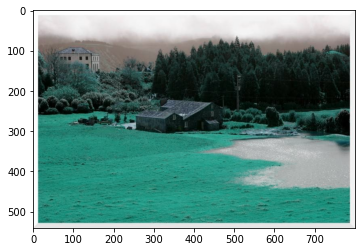

In [8]:
# Randomly generate a picture and display the image to verify the file path
from random import randint
id = randint(0, train.shape[0])
file = train['path'][id]
img = cv2.imread(file)
print("path:",file)
print("image size:", img.size)
plt.imshow(img)

In [9]:
#check if the landmark_id overlab
train.landmark_id.value_counts()

138982    6272
126637    2231
20409     1758
83144     1741
113209    1135
          ... 
84677        2
36989        2
133688       2
17316        2
111405       2
Name: landmark_id, Length: 81313, dtype: int64

<AxesSubplot:>

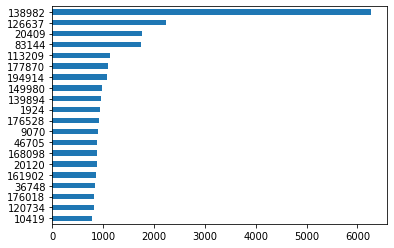

In [10]:
#show top 20 landmark_id
train.landmark_id.value_counts().head(20).sort_values().plot(kind = 'barh')

<AxesSubplot:>

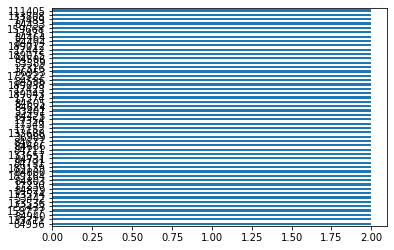

In [11]:
#show tail 50 landmark_id
train.landmark_id.value_counts().tail(50).sort_values().plot(kind = 'barh')

# Reduce the size of the data

In [12]:
#set landmark_id and count as dataframe
landmark_count = pd.DataFrame(train.landmark_id.value_counts())
landmark_count = landmark_count.reset_index()
#set columns name
landmark_count.columns.values[0] = "landmark_id"
landmark_count.columns.values[1] = "count"
landmark_count.head()

,landmark_id,count
0,138982,6272
1,126637,2231
2,20409,1758
3,83144,1741
4,113209,1135


In [13]:
#count total landmark
landmark_count.shape

(81313, 2)

In [14]:
#keep the landmark with count >= 500 only to increase accuracy
#remove some data for easy handling
landmark_count1 = landmark_count[landmark_count['count'] >= 500]
landmark_count1.shape

(51, 2)

In [15]:
#use inner join to remove the unwanted landmark
selected_df = pd.merge(train, landmark_count1, on = 'landmark_id', how='inner')
selected_df.drop('count', axis = 1, inplace = True)
selected_df.shape

(45579, 3)

In [16]:
selected_df.head()

,id,landmark_id,path
0,00cba0067c078490,27,../input/landmark-recognition-2020/train/0/0/c...
1,00f928e383e1d121,27,../input/landmark-recognition-2020/train/0/0/f...
2,0110a04e618bc368,27,../input/landmark-recognition-2020/train/0/1/1...
3,026afdc670937e3b,27,../input/landmark-recognition-2020/train/0/2/6...
4,0319627771784e54,27,../input/landmark-recognition-2020/train/0/3/1...


# Build Model - Method 1

In [17]:
val_split = 0.25
batch_size = 32
img_width = img_height = 192

In [18]:
#Generate train data, validation data set
datagen=ImageDataGenerator(validation_split=val_split,rescale=1. / 255)

train_generator=datagen.flow_from_dataframe(dataframe=selected_df,
                                            #directory="/kaggle/input/landmark-recognition-2020/train/",
                                            x_col="path",
                                            y_col="landmark_id",
                                            subset="training",
                                            batch_size=32,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=(img_height, img_width))

valid_generator=datagen.flow_from_dataframe(
dataframe=selected_df,
#directory="/kaggle/input/landmark-recognition-2020/train/",
x_col="path",
y_col="landmark_id",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_height, img_width))

Found 34185 validated image filenames belonging to 51 classes.
Found 11394 validated image filenames belonging to 51 classes.


In [19]:
def my_model(input_shape, num_classes, dropout, learning_rate = 0.0002):

    base_model = Xception(input_shape=input_shape,weights='imagenet', include_top=False)

    x = base_model.output
    x = L.Dropout(dropout)(x)
    x = L.SeparableConv2D(256, kernel_size=(3, 3), activation='relu',kernel_initializer = tf.keras.initializers.he_uniform(seed=1))(x)
    x = L.BatchNormalization()(x)
    x = L.SeparableConv2D(128, kernel_size=(3, 3), activation='relu',kernel_initializer = tf.keras.initializers.he_uniform(seed=3))(x)
    x = L.BatchNormalization()(x)
    x = L.SeparableConv2D(num_classes,kernel_size = (1,1), depth_multiplier=1, activation = 'relu',
                kernel_initializer = tf.keras.initializers.he_uniform(seed=0),
                kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.1, l2=0.01)
                )(x)
    x = L.GlobalMaxPooling2D()(x)
    x = L.BatchNormalization()(x)
    x = L.Flatten()(x)

    pred = L.Dense(num_classes, activation = 'softmax')(x)

    for layer in base_model.layers:
        layer.trainable = False

    model = Model(inputs = base_model.input,outputs = pred,name='model')

    model.compile(loss='categorical_crossentropy',experimental_steps_per_execution=8, optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01), metrics='categorical_accuracy')

    model.summary()
    return model

In [20]:
model = my_model(input_shape = (img_width, img_height, 3), num_classes = selected_df.landmark_id.nunique(), dropout = 0.5)

2022-08-07 22:38:41.184797: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 22:38:41.368384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 22:38:41.372365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-07 22:38:41.377577: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 95, 95, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 95, 95, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 95, 95, 32)   0           block1_conv1_bn[0][0]            
_____________________________

In [21]:
#Try to improve the model
epochs = 30 # Defining epochs for the model
#epochs = 1
train_samples  = int(len(selected_df)*(1-val_split))//batch_size
validation_samples  = int(len(selected_df)*val_split)//batch_size

print(train_samples)
print(validation_samples)

1068
356


In [22]:
# Define call backs and metrics:
checkpointer = ModelCheckpoint('basic_cnn.h5', monitor='val_loss', verbose=1, save_best_only=True)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

METRICS = [
    keras.metrics.Accuracy(name= "accuracy"),
    keras.metrics.Precision(name = "precision"),
    keras.metrics.Recall(name = 'recall'),
    keras.metrics.AUC(name = 'auc'),
]

In [23]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_samples // batch_size,
        epochs=epochs,
        callbacks=[checkpointer, early_stopping],
        use_multiprocessing=True,
        verbose=1,
        validation_data=valid_generator,
        validation_steps=validation_samples // batch_size,)

model.save("basic_cnn.h5")

2022-08-07 22:38:49.245674: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-08-07 22:38:58.022224: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 41s 1s/step - loss: 2.8467 - categorical_accuracy: 0.3646 - val_loss: 3.9673 - val_categorical_accuracy: 0.0000e+00

Epoch 00001: val_loss improved from inf to 3.96729, saving model to basic_cnn.h5
Epoch 2/30
33/33 [==============================] - 24s 734ms/step - loss: 2.2739 - categorical_accuracy: 0.4669 - val_loss: 3.9840 - val_categorical_accuracy: 0.0000e+00

Epoch 00002: val_loss did not improve from 3.96729
Epoch 3/30
33/33 [==============================] - 27s 822ms/step - loss: 1.8963 - categorical_accuracy: 0.5672 - val_loss: 4.0104 - val_categorical_accuracy: 0.0000e+00

Epoch 00003: val_loss did not improve from 3.96729
Epoch 4/30
33/33 [==============================] - 24s 724ms/step - loss: 1.7736 - categorical_accuracy: 0.5924 - val_loss: 4.0238 - val_categorical_accuracy: 0.0000e+00

Epoch 00004: val_loss did not improve from 3.96729
Epoch 5/30
33/33 [==============================] - 28s 860ms/step - loss: 1.6398 - categori

# Evaluation

In [24]:
#evaluate performance
scores = model.evaluate_generator(valid_generator, validation_samples, use_multiprocessing=True, verbose=1)
scores

356/356 [==============================] - 143s 401ms/step - loss: 4.2034 - categorical_accuracy: 0.0000e+00


[4.203407287597656, 0.0]

# Perfrom Prediction

In [25]:
#predict the output
#according to the competition, participant has to submit a file. The file has to contain id, landmarks and correspondence score

submission = pd.read_csv("/kaggle/input/landmark-recognition-2020/sample_submission.csv")
submission["path"] = submission.id.str[0]+"/"+submission.id.str[1]+"/"+submission.id.str[2]+"/"+submission.id+".jpg"
best_model = load_model("basic_cnn.h5")

test_gen = ImageDataGenerator().flow_from_dataframe(
    submission,
    directory="/kaggle/input/landmark-recognition-2020/test/",
    x_col="path",
    y_col=None,
    weight_col=None,
    target_size=(img_width, img_height),
    color_mode="rgb",
    classes=None,
    class_mode=None,
    batch_size=1,
    shuffle=True,
    subset=None,
    interpolation="nearest",
    validate_filenames=False)

Found 10345 non-validated image filenames.


In [26]:
y_pred_one_hot = best_model.predict_generator(test_gen, verbose=1, steps=len(submission))

10345/10345 [==============================] - 206s 20ms/step


In [27]:
y_pred = np.argmax(y_pred_one_hot, axis=-1)

y_prob = np.max(y_pred_one_hot, axis=-1)
print(y_pred.shape, y_prob.shape)

(10345,) (10345,)


In [28]:
y_uniq = np.unique(selected_df.landmark_id.values)
y_pred = [y_uniq[Y] for Y in y_pred]

In [29]:
for i in range(len(submission)):
    submission.loc[i, "landmarks"] = str(y_pred[i])+" "+str(y_prob[i])
submission = submission.drop(columns="path")
#submission.to_csv("submission.csv", index=False)
submission.head()

,id,landmarks
0,00084cdf8f600d00,189907 0.4858349
1,000b15b043eb8cf0,126637 0.5395469
2,0011a52f9b948fd2,189907 0.50240886
3,00141b8a5a729084,189907 0.728686
4,0018aa4b92532b77,189907 0.9311677
